# Intro to Machine Learning Project - Ada Zamora

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tools.feature_format import featureFormat, targetFeatureSplit

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectPercentile, f_classif, SelectKBest, mutual_info_regression, SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

from preliminar_analysis import count_num_of_pois, count_missing_values_per_feature
from feature_selection import percentile_feature_selection, kbest_feature_selection, get_important_features_names, \
    calculate_features_importance_scores, get_features_names_scores, create_ft_scores_barchart
from outliers_analysis import create_scatter_plot_color_pois, spot_first_outlier, spot_negative_restricted_stock, \
    spot_outliers
from new_features import add_poi_fraction_to_dict, add_sum_values_to_dict
from ml_classifiers import test_classifier_sss, scale_features, scaled_features_classifier_evaluation, evaluate_algorithms

In [2]:
# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

## Preliminary analysis

The goal of this project is to use supervised Machine Learning algorithms to predict persons of interest who might be related to the fraud that lead to the bankruptcy of Enron. Enron was a big "American energy, commodities, and services company" and on 2002 it was in bankruptcy due to fraud.

To accomplish this goal, we have a dataset with thousands of emails of the employees, we have financial information about Enron, and a list of "persons of interest", a hand generated list of people who were charged with crimes related to Enron, people who did not admit to be related to the fraud but paid fines and there were no criminal charges, and persons who testified in exchange for immunity from prosecution.

Given this data, machine learning is helpful to work with it because it we were able to scan big amounts of data, determine patters in it and make predictions. 

First of all, let's see how many data points we have in our data (each data point should correspond to a person)

In [3]:
print "total number of data points", len(data_dict)

total number of data points 146


Now, let's see how many persons of interest are in the dataset:

In [4]:
print count_num_of_pois(data_dict)

18


As in this project we want to classify POIs, having 146 data points and only 18 POIs is not the ideal scenario as this causes class imbalance. Machine learning algorithms work best when they have approximately the same number of classes, and in this case, only 12% of our data are POIs. To deal with this, we'll have to use ways to split the data maintaining the percentage of classes and to use some evaluation metrics that not only should take into account the number of data points labeled correctly, but the number of data points labeled correctly and incorrectly for each class (POI and non-POI).

In the dataset there are 21 features, where 14 are financial features and 6 are email features. The financial features are:

 ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)
 
The email features are:

['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

Checking the missing values of all the features:

In [5]:
print count_missing_values_per_feature(data_dict)

defaultdict(<type 'int'>, {'salary': 51, 'to_messages': 60, 'deferral_payments': 107, 'total_payments': 21, 'long_term_incentive': 80, 'loan_advances': 142, 'bonus': 64, 'restricted_stock': 36, 'restricted_stock_deferred': 128, 'total_stock_value': 20, 'shared_receipt_with_poi': 60, 'from_poi_to_this_person': 60, 'exercised_stock_options': 44, 'from_messages': 60, 'other': 53, 'from_this_person_to_poi': 60, 'deferred_income': 97, 'expenses': 51, 'email_address': 35, 'director_fees': 129})


We can see that the feature with more missing values is deferral payments, with 107 values missing, while the feature with less missing values is total stock value, with only 20 values missing.

## Task 1: Select what features you'll use

To start with feature selection, I'll evaluate all of the numerical features of the dataset, so I will not take into account the email address feature.

In [6]:
all_features_list = ["poi", "salary", "to_messages", "deferral_payments", "total_payments", 
                     "exercised_stock_options", "bonus", "restricted_stock", "shared_receipt_with_poi", 
                     "restricted_stock_deferred", "total_stock_value", "expenses", "loan_advances", 
                     "from_messages", "other", "from_this_person_to_poi", "director_fees", 
                     "deferred_income", "long_term_incentive", "from_poi_to_this_person"]

In [7]:
len(all_features_list)

20

I want to have an idea of the features' importances in the dataset, so I'll calculate the importance of each feature using a tree-based feature selection:

In [8]:
data = featureFormat(data_dict, all_features_list)
labels, features = targetFeatureSplit(data)

In [9]:
importances = calculate_features_importance_scores(features, labels)

Now I want to see the name of each feature with its corresponding importance score:

In [10]:
names, values = get_features_names_scores(all_features_list, importances)

[['shared_receipt_with_poi' '0.102922323477']
 ['from_this_person_to_poi' '0.0840401862636']
 ['deferred_income' '0.0835925727245']
 ['expenses' '0.0789326253186']
 ['other' '0.0694569617929']
 ['exercised_stock_options' '0.0684420513103']
 ['total_payments' '0.0666561500946']
 ['bonus' '0.0656683784346']
 ['restricted_stock' '0.0650278177353']
 ['total_stock_value' '0.0648700684841']
 ['from_poi_to_this_person' '0.0519419458324']
 ['salary' '0.0444285896479']
 ['long_term_incentive' '0.043981407042']
 ['from_messages' '0.0358161910989']
 ['to_messages' '0.0321811619726']
 ['deferral_payments' '0.0264248692398']
 ['loan_advances' '0.00658859855197']
 ['director_fees' '0.00458171972181']
 ['restricted_stock_deferred' '0.004446381257']]


And visualize it in a bar chart:

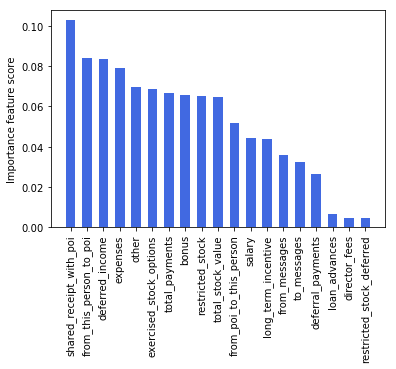

In [11]:
create_ft_scores_barchart(names, values)

We can see here that there's clearly a feature who stands out, although its importance is only 0.10. This is shared_receipt_with_poi.

Then, we have 3 feature whose importance is about 0.08, these features are: from_this_person_to_poi, deferred_income and expenses. Then, 6 features with an importance score of about 0.07.

The features with less importance score are loan_advances, director_fees and restricted_stock_deferred.

I'll also do feature selection using percentile and k-best algorithms, I want to see the top 9 features these algorithms will select.

In [12]:
percentile = percentile_feature_selection(features, labels, 50)
print "important features percentile", get_important_features_names(all_features_list, percentile)

kbest = kbest_feature_selection(features, labels, 9)
print "\n important features kbest", get_important_features_names(all_features_list, kbest)

important features percentile ['to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'shared_receipt_with_poi', 'loan_advances', 'from_this_person_to_poi', 'director_fees', 'from_poi_to_this_person']

 important features kbest ['salary', 'bonus', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'other', 'from_this_person_to_poi', 'director_fees']


Draws my attention the difference between the features selected in each method. Comparing the features obtained with percentile with the top nine who had a higher score, only 3 features coincide. In the case of k-best, this list shares 6 features with the ones obtained in the top nine features with highest score.

This difference might be because there's not a very clear feature who seems to be driving most of the patterns in the data, so each method returns different results.

## Task 2: Remove outliers

On class, we found an outlier as part of a mini-project, so I'll follow the steps that lead to finding and dealing with that outliert here: First, I'll plot bonus vs salary

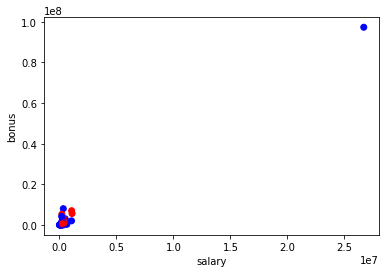

In [13]:
create_scatter_plot_color_pois(data_dict, ["poi", "salary", "bonus"])

There's a single point with a value of salary and bonus way higher than the rest of the points, so I'll check the person related to that point

In [14]:
spot_first_outlier(data_dict, ["salary", "bonus"])

highest salary 26704229 TOTAL
highest bonus 97343619 TOTAL


This value represents the total of the spredsheet and does not refer to a person in Enron, so I'll delete this data point from the dictionary

In [15]:
data_dict.pop("TOTAL", 0)

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

Now I'll make the plot again: 

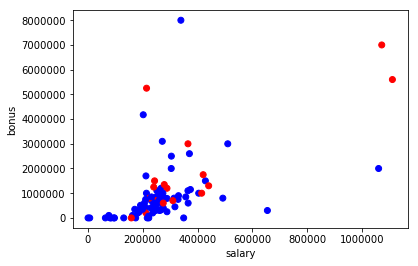

In [16]:
create_scatter_plot_color_pois(data_dict, ["poi", "salary", "bonus"])

Here we can see that after removing the outlier, there's a better distribution of the data points. This outlier (TOTAL) was the one we found on the mini-project.

Now I want to plot the exercised stock options vs the restricted stock options:

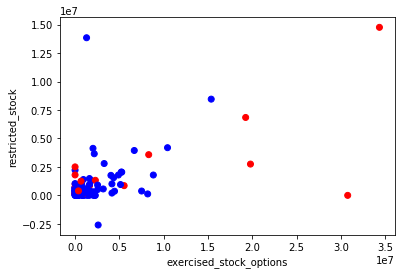

In [17]:
create_scatter_plot_color_pois(data_dict, ["poi", "exercised_stock_options", "restricted_stock"])

In [18]:
spot_negative_restricted_stock(data_dict)

negative_restricted_stock -2604490 BHATNAGAR SANJAY


I found that BHATNAGAR SANJAY has a negative restricted_stock_option of -2604490, but when I checked his data on the financial pdf, I see that value is positive, so this outlier is probably a typing error, I'll change its value to positive.

In [19]:
(data_dict["BHATNAGAR SANJAY"]["restricted_stock"]) = (data_dict["BHATNAGAR SANJAY"]["restricted_stock"])*-1

Plotting the data again to see how it looks:

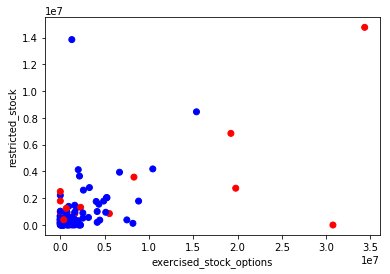

In [20]:
create_scatter_plot_color_pois(data_dict, ["poi", "exercised_stock_options", "restricted_stock"])

I see several ouliers in this case, and some of them are pois and some other not. I want to check some of those outliers to see who they are. I'll clasify as outliers persons with a value of exercised stock option greater than 13,000,000 usd and/or a value of restricted stock greater than 6,000,000

In [21]:
spot_outliers(data_dict, ["exercised_stock_options", "restricted_stock"], 13000000, 6000000)

outliers_both_features defaultdict(<type 'int'>, {'SKILLING JEFFREY K': [(19250000, 6843672), True], 'LAY KENNETH L': [(34348384, 14761694), True], 'PAI LOU L': [(15364167, 8453763), False]})

outliers exercised_stock_options defaultdict(<type 'int'>, {'RICE KENNETH D': [19794175, True]})

outliers restricted_stock defaultdict(<type 'int'>, {'WHITE JR THOMAS E': [13847074, False]})


There are two people that draw my attention here: Lou Pai and Thomas White. 


Lou Pai has very high values of exercised and restricted stock options but he's not listed as an outlier. 

After investigating who Lou Pai is, I found this: "Pai joined Enron in 1987, when it was still just a regional energy supplier. He became one of (eventual) CEO Jeffrey Skilling’s top lieutenants, primarily tasked with detailing and implementing Skilling’s vision of transforming Enron into a de facto energy-commodities-trading firm. During his Enron career, Skilling put Pai in charge of multiple Enron subsidiaries; Pai was CEO of the EES (Enron Energy Services) subsidiary from March 1997, until May 2001" from https://en.wikipedia.org/wiki/Lou_Pai 

Also, "Lou Pai settled out of court for $31.5 million." from https://en.wikipedia.org/wiki/Enron

Given those facts, I believe Lou Pai should be a POI.

Regarding Thomas White, he was Vice Chairman of Enron Energy Services (https://en.wikipedia.org/wiki/Thomas_E._White) and while having that charge "... White had actively pursued military contracts for the company and in 1999 had secured a prototype deal at Fort Hamilton for privatizing the power supply of army bases. Enron had been the only bidder for this deal after White had controversially used his government and military contacts to secure key concessions." 

"The Washington Post reported that in late October 2001, White made numerous phone calls to Enron executives including Vice President Jude Rolfes, former CEO Jeff Skilling and President current CEO Ken Lay. Shortly after the calls were made, White unloaded 200,000 Enron shares for $12 million." 

Given these facts, I believe he should also be listed as a person of interest.

In [22]:
# Changing Lou Pai and Thomas White to pois

data_dict["PAI LOU L"]["poi"] = True
data_dict["WHITE JR THOMAS E"]["poi"] = True

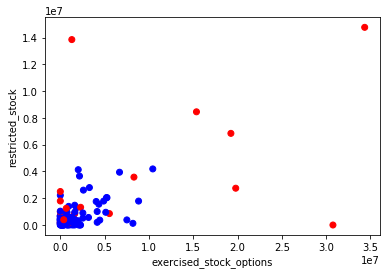

In [23]:
# Making the plot again
create_scatter_plot_color_pois(data_dict, ["poi", "exercised_stock_options", "restricted_stock"])

In this plot we can see that all of the employees with an exercised stock options value of over 13,000,000 usd and/or a value of 6,000,000 usd in restricted stock are POIs.

  Now I want to plot salary vs bonus: 

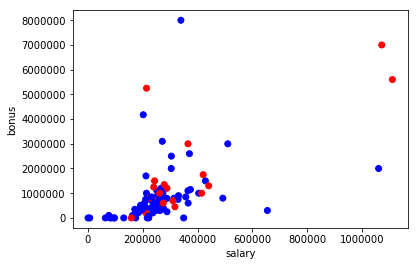

In [24]:
create_scatter_plot_color_pois(data_dict, ["poi", "salary", "bonus"])

There does not seem to be a patter here, but as I did with the previous plot, I'll check the outliers: employees with a salary higher than 600,000 usd and bonus higher than 4,000,000 usd

In [25]:
spot_outliers(data_dict, ["salary", "bonus"], 600000, 4000000)

outliers_both_features defaultdict(<type 'int'>, {'SKILLING JEFFREY K': [(1111258, 5600000), True], 'LAY KENNETH L': [(1072321, 7000000), True]})

outliers salary defaultdict(<type 'int'>, {'FREVERT MARK A': [1060932, False], 'PICKERING MARK R': [655037, False]})

outliers bonus defaultdict(<type 'int'>, {'LAVORATO JOHN J': [8000000, False], 'BELDEN TIMOTHY N': [5249999, True], 'ALLEN PHILLIP K': [4175000, False]})


I see several employees that match this criteria. Both of the employees with outliers on both features are POIs

I did some research on the other outliers and I conclude that:

From salary outliers only:
Mark Frevert does not seem like a poi
Mark Pickering does not seem like a poi 

From bonus outliers only:
John Lavorato does not seem like a poi
Phillip allen does not seem like a poi

That said, there does not seem to be a clear trend in the data that classifies pois and non-pois

Now I'll plot salary vs long term incentive:

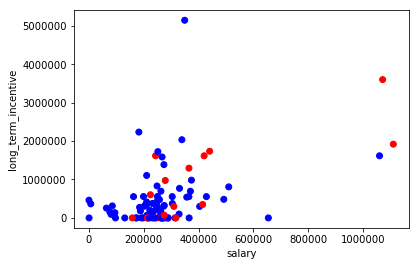

In [26]:
create_scatter_plot_color_pois(data_dict, ["poi", "salary", "long_term_incentive"])

And check the ouliers:

In [27]:
spot_outliers(data_dict, ["salary", "long_term_incentive"], 600000, 3000000)

outliers_both_features defaultdict(<type 'int'>, {'LAY KENNETH L': [(1072321, 3600000), True]})

outliers salary defaultdict(<type 'int'>, {'FREVERT MARK A': [1060932, False], 'SKILLING JEFFREY K': [1111258, True]})

outliers long_term_incentive defaultdict(<type 'int'>, {'MARTIN AMANDA K': [5145434, False]})


The only outlier on both features is Kenneth Lay (a POI).

After investigating about Amanda Martin, the outlier of long term incentive only, I conclude she does not seem like a poi

## Task 3: Create new features

In class we added several new features who seem to be good discriminators between pois and non-pois, those are the fraction of emails sent to pois and the fraction of email received from pois, so I'll create those features here:

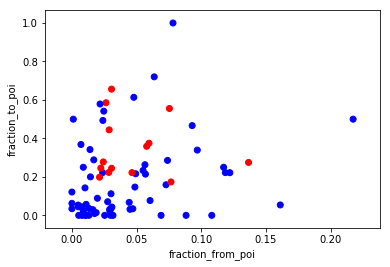

In [28]:
add_poi_fraction_to_dict(data_dict, "fraction_from_poi", "from_poi_to_this_person", "to_messages")
add_poi_fraction_to_dict(data_dict, "fraction_to_poi", "from_this_person_to_poi", "from_messages")
create_scatter_plot_color_pois(data_dict, ["poi", "fraction_from_poi", "fraction_to_poi"])

In this plot there's is a trend that indicates that if a person had less than 20% of their emails sent to POIs, that person is probably not a POI.

I want to see if there's a relationship between bonus and long term incentive, as those features roughly refer to the same: incentives to employees.

I'll plot bonus vs long term incentive:

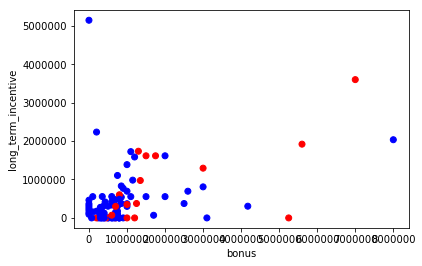

In [29]:
create_scatter_plot_color_pois(data_dict, ["poi", "bonus", "long_term_incentive"])

I don't see any apparent relationship between the features, so I'll create new features who refer to each incentive divided by the salary as I want to have an idea of the magnitude of the bonuses some people received, I believe it should be a red flag if someone received a bonus of more than 10 or 15 times his/her salary.

I'll call the new features bonus/salary and long_term/salary and I'll plot them:

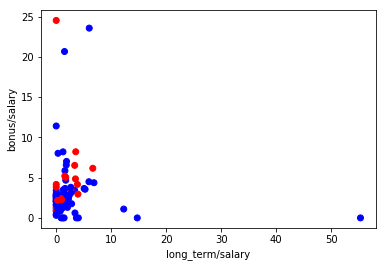

In [30]:
add_poi_fraction_to_dict(data_dict, "bonus/salary", "bonus", "salary")

add_poi_fraction_to_dict(data_dict, "long_term/salary", "long_term_incentive", "salary")

create_scatter_plot_color_pois(data_dict, ["poi", "long_term/salary", "bonus/salary"])

I see several outliers in this plot: a person who received a long term incentive of over 50 times his/her salary, and 3 people who received a bonus of over 20 times their salary. I'll check the names of these people:

In [31]:
spot_outliers(data_dict, ["long_term/salary", "bonus/salary"], 20, 15)

outliers_both_features defaultdict(<type 'int'>, {})

outliers long_term/salary defaultdict(<type 'int'>, {'GRAY RODNEY': [55.27210884353742, False]})

outliers bonus/salary defaultdict(<type 'int'>, {'LAVORATO JOHN J': [23.57878852184575, False], 'BELDEN TIMOTHY N': [24.532820246823583, True], 'ALLEN PHILLIP K': [20.672922185635414, False]})


The outlier that draws most of my attention is Rodney Gray, who recived a bonus of 55 times his salary. I'll check his salary and the bonus he received:

In [32]:
print data_dict["GRAY RODNEY"]["salary"]
print data_dict["GRAY RODNEY"]["long_term_incentive"]

6615
365625


In the data and the pdf containing the financial data, Rodney Gray is listed to have a salary of 6,615 usd. I believe this is an outlier as he was a Chief Executive Officer at Enron and it is very unlikely his salary was this low
https://www.bloomberg.com/research/stocks/private/person.asp?personId=438862&privcapId=337480

After seeing this outlier, I found another one in the financial data pdf, Bannantine James M, whose salary is listed as 477, which is very unlikely as he was Chief Executive Officer for Enron South America
http://www.atcapgroup.com/team/bannantine.html

To deal with these outliers, I've decided to change the salary in both cases to "NaN"

In [33]:
data_dict["GRAY RODNEY"]["salary"] = "NaN"
data_dict["BANNANTINE JAMES M"]["salary"] = "NaN"

Regarding the outliers in bonus/salary who received a bonus of over 20 times their salary: 
- John Lavorato 
- Timothy Belden
- Phillip Allen

All of them were top executives at Enron and they actually received very high bonuses before Enron collapsed, this is mentioned here: http://www.nytimes.com/2002/06/18/business/officials-got-a-windfall-before-enron-s-collapse.html

As I did some changes to the data, now I need to create and plot the features again:

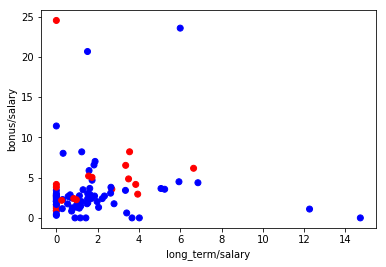

In [34]:
add_poi_fraction_to_dict(data_dict, "bonus/salary", "bonus", "salary")

add_poi_fraction_to_dict(data_dict, "long_term/salary", "long_term_incentive", "salary")

create_scatter_plot_color_pois(data_dict, ["poi", "long_term/salary", "bonus/salary"])

In this plot there does not seem to be a clear trend between the variables and the POIs as there are some employees who received very high bonuses and are not POIs.

Now I'll create a new feature, sum_bonus, where I'll sum the variables bonus and long term incentive and I'll plot the employees sum_bonus vs the salary

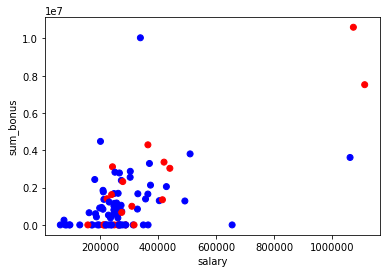

In [35]:
add_sum_values_to_dict(data_dict, "sum_bonus", "bonus", "long_term_incentive")

create_scatter_plot_color_pois(data_dict, ["poi", "salary", "sum_bonus"])

Again, there does not seem to be a clear trend between the salary and the sum of bonus who can help us discriminate POIs from non-POIs.

I'll plot the sum_bonus vs expenses to see if I get some information:

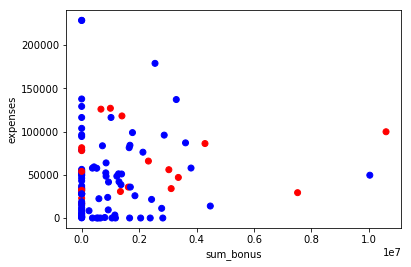

In [36]:
create_scatter_plot_color_pois(data_dict, ["poi", "sum_bonus", "expenses"])

This plot is not very illustrative as there are a variety of points with a zero value in expenses and a zero value in bonus, some POIs included.

Now that I added 5 new features, I want to calculate the features' importance score again:

In [37]:
features_list = ["poi", "salary", "to_messages", "deferral_payments", "total_payments", "exercised_stock_options",
                     "bonus", "restricted_stock", "shared_receipt_with_poi", "restricted_stock_deferred",
                     "total_stock_value", "expenses", "loan_advances", "from_messages", "other",
                     "from_this_person_to_poi", "director_fees", "deferred_income", "long_term_incentive",
                     "from_poi_to_this_person", "fraction_from_poi", "fraction_to_poi", "bonus/salary",
                 "long_term/salary", "sum_bonus"]

data = featureFormat(data_dict, features_list, sort_keys=True)
labels, features = targetFeatureSplit(data)

In [38]:
importance_score = calculate_features_importance_scores(features, labels)

ft_names, ft_importances = get_features_names_scores(features_list, importance_score)

[['total_stock_value' '0.108697987252']
 ['fraction_to_poi' '0.0942950730201']
 ['bonus' '0.0880860329986']
 ['restricted_stock' '0.0865500602946']
 ['expenses' '0.0560678735771']
 ['bonus/salary' '0.0545718042687']
 ['other' '0.0542124102203']
 ['salary' '0.0532510445893']
 ['exercised_stock_options' '0.0500825973733']
 ['shared_receipt_with_poi' '0.048263898501']
 ['total_payments' '0.038226609654']
 ['long_term_incentive' '0.0370027306064']
 ['sum_bonus' '0.0345348030734']
 ['fraction_from_poi' '0.0341131783236']
 ['from_poi_to_this_person' '0.032665529916']
 ['from_this_person_to_poi' '0.0301781966899']
 ['deferred_income' '0.020571561848']
 ['long_term/salary' '0.0195090270059']
 ['to_messages' '0.0183670617807']
 ['deferral_payments' '0.0161659180845']
 ['from_messages' '0.0141351826542']
 ['loan_advances' '0.00898058930317']
 ['director_fees' '0.00105772173594']
 ['restricted_stock_deferred' '0.000413107229377']]


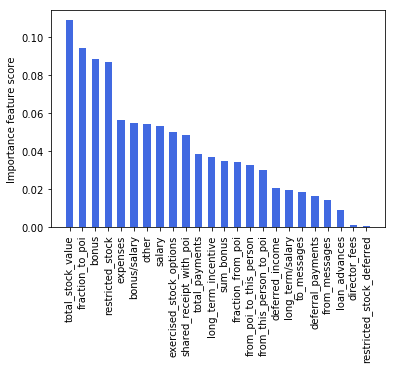

In [39]:
create_ft_scores_barchart(ft_names, ft_importances)

Here we can see that two of the new features created are in the top-ten most important features. These are: fraction_to_poi and bonus/salary.

fraction_to_poi has the second highest importance score, which corresponds to the trend we visualized in the fraction_to_poi vs fraction_from_poi plot: employees with less than 20% of their emails sent to POIs, are not POIs.

## Task 4: Try a variety of classifiers

As we have a small number of data points, and from that data, only 12% are POIS, I decided to use Stratified Suffle Split to validate the algorithms I'll try. This way, I can have several folds of the data and each fold will have roughly the same proportion of classes, so this will be a better validation to the algorithms' performance. For each algorithm to test, I'll try with 1000 folds.

I'll try a variety of classifiers using different input features.

For each features selection, I'll use Naive Bayes, Decision tree and K-nearest neighbor classifiers to test their performance. I also tried Support Vector Machine, but in each of the cases I tested, the accuracy and recall were zero, and that means the algorithm could not make any true positive prediction, so I decided to exclude this algorithm of the report.

In the case of Naive Bayes and K-nearest neighbor, I'll also do feature scaling every time I'll try an algorithm. 

That said, for each set of features to try, I'll calculate accuracy, precision and recall in these cases:
- Decision Tree classifier using the input features
- Naive Bayes classifier using the non-scaled features, the features scaled with a min-max scaler and the features scaled with a robust scaler
- K nearest neighbor classifier using the non-scaled features, the features scaled with a min-max scaler and the features scaled with a robust scaler

In the case of feature scaling for Naive Bayes and K nearest neighbor classifiers, I decided to use two types of scaling: min max scaler and robust scaler. 

MinMaxScaler takes the minimum and maximum value of the data and transforms the data from 0 to 1, being 0 the minimum and 1 the maximun. As we have several outliers in this data (especially, people with very high salaries and bonuses), I also used RobustScaler as "the centering and scaling statistics of this scaler are based on percentiles and are therefore not influenced by a few number of very large marginal outliers" (http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

I did not perform feature scaling on Decision Tree classifiers, as this algorithm is independent of the features scales, so we would get the same results if we scale the features than if we don't. 

First, I'll try the classifiers with all features available (including the new features I added):

In [40]:
features_list = ["poi", "salary", "to_messages", "deferral_payments", "total_payments", "exercised_stock_options",
                     "bonus", "restricted_stock", "shared_receipt_with_poi", "restricted_stock_deferred",
                     "total_stock_value", "expenses", "loan_advances", "from_messages", "other",
                     "from_this_person_to_poi", "director_fees", "deferred_income", "long_term_incentive",
                     "from_poi_to_this_person", "fraction_from_poi", "fraction_to_poi", "bonus/salary",
                 "long_term/salary", "sum_bonus"]

data = featureFormat(data_dict, features_list, sort_keys=True)
labels, features = targetFeatureSplit(data)

In [41]:
evaluate_algorithms(features, labels)

DecisionTreeClassifier:
	Accuracy: 0.823		Precision: 0.364	Recall: 0.394

GaussianNB:

Features non-scaled
	Accuracy: 0.681		Precision: 0.222	Recall: 0.536

Features min max scaled
	Accuracy: 0.572		Precision: 0.203	Recall: 0.729

Features robust scaled
	Accuracy: 0.346		Precision: 0.163	Recall: 0.922

KNeighborsClassifier:

Features non-scaled
	Accuracy: 0.886		Precision: 0.842	Recall: 0.199

Features min max scaled
	Accuracy: 0.857		Precision: 0.378	Recall: 0.074

Features robust scaled
	Accuracy: 0.881		Precision: 0.858	Recall: 0.154



In this case, the best performing algorithm seems to be Decision tree. K-neighbors has a very good accuracy and precision using the non scaled and robust scaled features, but the recall is quite low, which means that it predicted as non POIs, people who were actually POIs. And, Naive Bayes has a high recall but very low precision, indicating that it predicted as POI people who were not POIs.

Now I'll try using less features. I'll do feature selection again to see the most important features, now that I've added new features:

In [42]:
data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

percentile = percentile_feature_selection(features, labels, 50)
print "important features percentile", get_important_features_names(features_list, percentile)

kbest = kbest_feature_selection(features, labels, 10)
print "\nimportant features kbest", get_important_features_names(features_list, kbest)

important features percentile ['salary', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'total_stock_value', 'expenses', 'deferred_income', 'long_term_incentive', 'fraction_to_poi', 'bonus/salary', 'sum_bonus']

important features kbest ['exercised_stock_options', 'bonus', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'director_fees', 'fraction_to_poi', 'long_term/salary']


I see that in the important feature there are included total_payments and total_stock_value, so I'll remove them from the features list as those variables are the sum of other variables already included in the features. Then, I'll do feature selection again.

In [43]:
features_list_no_totals = ["poi", "salary", "to_messages", "deferral_payments", "exercised_stock_options",
                     "bonus", "restricted_stock", "shared_receipt_with_poi", "restricted_stock_deferred",
                     "expenses", "loan_advances", "from_messages", "other",
                     "from_this_person_to_poi", "director_fees", "deferred_income", "long_term_incentive",
                     "from_poi_to_this_person", "fraction_from_poi", "fraction_to_poi", "bonus/salary",
                     "long_term/salary"]

data = featureFormat(data_dict, features_list_no_totals)
labels, features = targetFeatureSplit(data)

percentile = percentile_feature_selection(features, labels, 50)
features_list_no_totals_percentile = ["poi"] + get_important_features_names(features_list_no_totals, percentile)
print "important features percentile", features_list_no_totals_percentile

kbest = kbest_feature_selection(features, labels, 10)
features_list_no_totals_kbest = ["poi"] + get_important_features_names(features_list_no_totals, kbest)

print "\nimportant features kbest", features_list_no_totals_kbest

important features percentile ['poi', 'salary', 'exercised_stock_options', 'bonus', 'restricted_stock', 'expenses', 'loan_advances', 'deferred_income', 'long_term_incentive', 'fraction_to_poi', 'bonus/salary']

important features kbest ['poi', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'expenses', 'loan_advances', 'other', 'from_this_person_to_poi', 'deferred_income', 'fraction_to_poi', 'bonus/salary']


I find strange that in the k-best method, "other" is selected as a feature of interest, and I find interesting that with kbest, the fraction_to_poi and from_this_person_to_poi feature are selected. Both of these features refer to the same but one of them is the relation between the number of emails sent to POIs and the total number of emails sent while the other refers to the absolute value of emails sent to POIs.

Also, in percentile and kbest, the new feature bonus/salary is considered a feature of interest.

I'll try the features obtained using the percentile method in the machine learning algorithms:

In [44]:
data = featureFormat(data_dict, features_list_no_totals_percentile, sort_keys=True)
labels, features = targetFeatureSplit(data)

In [45]:
evaluate_algorithms(features, labels)

DecisionTreeClassifier:
	Accuracy: 0.810		Precision: 0.319	Recall: 0.315

GaussianNB:

Features non-scaled
	Accuracy: 0.760		Precision: 0.287	Recall: 0.485

Features min max scaled
	Accuracy: 0.812		Precision: 0.353	Recall: 0.416

Features robust scaled
	Accuracy: 0.635		Precision: 0.122	Recall: 0.262

KNeighborsClassifier:

Features non-scaled
	Accuracy: 0.882		Precision: 0.844	Recall: 0.188

Features min max scaled
	Accuracy: 0.844		Precision: 0.289	Recall: 0.079

Features robust scaled
	Accuracy: 0.865		Precision: 0.569	Recall: 0.142



Here, the best performing algorithm is Naive Bayes with the features scaled using the MinMaxScale method. It has an accuracy of 0.812, precision of 0.353 and recall of 0.416

Now I'll try using the features obtained from K-best:

In [46]:
data = featureFormat(data_dict, features_list_no_totals_kbest, sort_keys=True)
labels, features = targetFeatureSplit(data)

In [47]:
evaluate_algorithms(features, labels)

DecisionTreeClassifier:
	Accuracy: 0.803		Precision: 0.317	Recall: 0.330

GaussianNB:

Features non-scaled
	Accuracy: 0.680		Precision: 0.205	Recall: 0.431

Features min max scaled
	Accuracy: 0.776		Precision: 0.282	Recall: 0.365

Features robust scaled
	Accuracy: 0.654		Precision: 0.122	Recall: 0.229

KNeighborsClassifier:

Features non-scaled
	Accuracy: 0.853		Precision: 0.427	Recall: 0.093

Features min max scaled
	Accuracy: 0.838		Precision: 0.245	Recall: 0.063

Features robust scaled
	Accuracy: 0.856		Precision: 0.484	Recall: 0.114



In this case, the best performing algorithm is Decision tree, with an accuracy of over 0.8 and both precision and recall over 0.3. Again, we see the same pattern we had as when we used all features: Naive Bayes has a low precision with high recall, while K neighbors has a low recall and high precision.

As I've removed some features to do testing ,I'd like to check the importance scores of the new features list:

In [48]:
data = featureFormat(data_dict, features_list_no_totals)
labels, features = targetFeatureSplit(data)

In [49]:
importances = calculate_features_importance_scores(features, labels)
names, values = get_features_names_scores(features_list_no_totals, importances)

[['restricted_stock' '0.155146403057']
 ['exercised_stock_options' '0.0915893306741']
 ['shared_receipt_with_poi' '0.0783442478863']
 ['expenses' '0.0713960650732']
 ['deferred_income' '0.0684595059304']
 ['fraction_to_poi' '0.0655067122315']
 ['other' '0.0636436177897']
 ['bonus' '0.0585144834939']
 ['long_term/salary' '0.0528371306773']
 ['from_poi_to_this_person' '0.0469762072343']
 ['long_term_incentive' '0.0441238609807']
 ['from_this_person_to_poi' '0.042190691955']
 ['bonus/salary' '0.035035638389']
 ['fraction_from_poi' '0.0300294616356']
 ['from_messages' '0.0252751522671']
 ['to_messages' '0.0241721342801']
 ['deferral_payments' '0.016099083554']
 ['salary' '0.0139607548636']
 ['loan_advances' '0.0124910314805']
 ['restricted_stock_deferred' '0.00406451612903']
 ['director_fees' '0.000143970417303']]


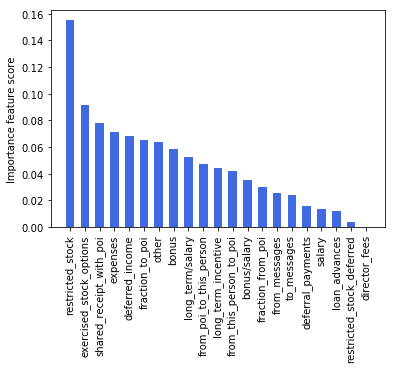

In [50]:
create_ft_scores_barchart(names, values)

Now I see a new feature who clearly stands out from the other: restricted_stock, with an importance score of almost 0.16, while the second one is exercised_stock_options, with an importance score of about 0.9.

Some of the most important features according to the importance score are listed in the features I obtained using percentile and k-best algorithms to do feature selection, but also, in percentile and kbest, loan advances is listed as an important feature and here is the one of the lowest scores.

Given this difference, I'll create a hand-generated features list, taking into consideration the features importance score I just calculated and plotted. I'll only exclude in this list the last three features who have the lower importance score. After that, I'll try the algorithms again to see how they perform.

In [51]:
features_best_scores = ["poi", "salary", "to_messages", "deferral_payments", "exercised_stock_options",
                     "bonus", "restricted_stock", "shared_receipt_with_poi", "expenses", "from_messages", 
                    "other", "from_this_person_to_poi", "deferred_income", "long_term_incentive",
                     "from_poi_to_this_person", "fraction_from_poi", "fraction_to_poi", "bonus/salary",
                     "long_term/salary"]

In [52]:
data = featureFormat(data_dict, features_best_scores, sort_keys=True)
labels, features = targetFeatureSplit(data)

In [53]:
evaluate_algorithms(features, labels)

DecisionTreeClassifier:
	Accuracy: 0.808		Precision: 0.316	Recall: 0.321

GaussianNB:

Features non-scaled
	Accuracy: 0.854		Precision: 0.475	Recall: 0.431

Features min max scaled
	Accuracy: 0.831		Precision: 0.401	Recall: 0.426

Features robust scaled
	Accuracy: 0.831		Precision: 0.401	Recall: 0.426

KNeighborsClassifier:

Features non-scaled
	Accuracy: 0.888		Precision: 0.904	Recall: 0.222

Features min max scaled
	Accuracy: 0.853		Precision: 0.336	Recall: 0.058

Features robust scaled
	Accuracy: 0.867		Precision: 0.732	Recall: 0.074



In this case, the algorithm with a better performance is Naive Bayes using the non-scaled features, with an accuracy of 0.854, precision of 0.475 and a recall of 0.431, using scaled features, this algorithm had a similar performance (but a bit lower).

The worst performance algorithm is K neighbors, where we see again the trend on high precision and low recall.

Now I'll try to do PCA. In this case I'll use all features available:

In [54]:
features_list = ["poi", "salary", "to_messages", "deferral_payments", "total_payments", "exercised_stock_options",
                     "bonus", "restricted_stock", "shared_receipt_with_poi", "restricted_stock_deferred",
                     "total_stock_value", "expenses", "loan_advances", "from_messages", "other",
                     "from_this_person_to_poi", "director_fees", "deferred_income", "long_term_incentive",
                     "from_poi_to_this_person", "fraction_from_poi", "fraction_to_poi", "bonus/salary",
                 "long_term/salary", "sum_bonus"]

data = featureFormat(data_dict, features_list, sort_keys=True)
labels, features = targetFeatureSplit(data)

In [55]:
print "DecisionTreeClassifier"
estimators = [('reduce_dim', PCA()), ('clf', DecisionTreeClassifier())]
clf = Pipeline(estimators)
test_classifier_sss(clf, features, labels)

estimators = [('reduce_dim', PCA()), ('clf', GaussianNB())]
clf = Pipeline(estimators)
scaled_features_classifier_evaluation(clf, features, labels)

estimators = [('reduce_dim', PCA()), ('clf', KNeighborsClassifier())]
clf = Pipeline(estimators)
scaled_features_classifier_evaluation(clf, features, labels)

DecisionTreeClassifier
	Accuracy: 0.799		Precision: 0.303	Recall: 0.367

GaussianNB:

Features non-scaled
	Accuracy: 0.849		Precision: 0.439	Recall: 0.385

Features min max scaled
	Accuracy: 0.798		Precision: 0.307	Recall: 0.386

Features robust scaled
	Accuracy: 0.582		Precision: 0.154	Recall: 0.459

KNeighborsClassifier:

Features non-scaled
	Accuracy: 0.886		Precision: 0.842	Recall: 0.199

Features min max scaled
	Accuracy: 0.857		Precision: 0.378	Recall: 0.074

Features robust scaled
	Accuracy: 0.881		Precision: 0.858	Recall: 0.154



In this case, the best performing algorithm is again Naive Bayes with non-scaled features, with an accuracy of 0.849, precision of 0.439 and recall of 0.385, all these three values, are lower than the ones obtained with features_best_scores.

I want to see if using PCA with the features_best_scores improves the performance:

In [56]:
# PCA with features with best scores

data = featureFormat(data_dict, features_best_scores, sort_keys=True)
labels, features = targetFeatureSplit(data)

print "DecisionTreeClassifier"
estimators = [('reduce_dim', PCA()), ('clf', DecisionTreeClassifier())]
clf = Pipeline(estimators)
test_classifier_sss(clf, features, labels)

estimators = [('reduce_dim', PCA()), ('clf', GaussianNB())]
clf = Pipeline(estimators)
scaled_features_classifier_evaluation(clf, features, labels)

estimators = [('reduce_dim', PCA()), ('clf', KNeighborsClassifier())]
clf = Pipeline(estimators)
scaled_features_classifier_evaluation(clf, features, labels)

DecisionTreeClassifier
	Accuracy: 0.808		Precision: 0.326	Recall: 0.350

GaussianNB:

Features non-scaled
	Accuracy: 0.839		Precision: 0.426	Recall: 0.443

Features min max scaled
	Accuracy: 0.796		Precision: 0.325	Recall: 0.428

Features robust scaled
	Accuracy: 0.822		Precision: 0.380	Recall: 0.440

KNeighborsClassifier:

Features non-scaled
	Accuracy: 0.888		Precision: 0.904	Recall: 0.222

Features min max scaled
	Accuracy: 0.853		Precision: 0.336	Recall: 0.058

Features robust scaled
	Accuracy: 0.867		Precision: 0.732	Recall: 0.074



Again, the best performance algorithm is Naive Bayes with non-scaled features, but the accuracy and precision are lower than the ones obtained with features_best_scores and no PCA.

After trying all of the algorithms, I came to several conclusions:
- Decision tree performed well in all of the cases studied, giving always an accuracy of above 0.8 and precision and recall of above 0.3
- K nearest neighbors is the algorithm with the wost performance in all of the cases studied. Always following a clear pattern of having high precision but very low accuracy, which means that in most cases, this algorithm predicted as non POIs, people who were actually POIs. 
- Naive Bayes also showed in some cases a trend of having low precision and high recall (it predicted as POI people who where not POIs), but in other cases, had very good accuracy, precision and recall scores. Actually, this algorithm is the one who has the two best performances.
- In this specific data, feature scaling didn't seem to make an important difference in the algorithms' performance. The only case where I found a clear difference, was when I tried the features selected using percentile after removing the "totals", in which the better algorithm was Naive Bayes with the features scaled using the MinMaxScale method.

## Task 5: Tune your classifier to achieve better than .3 precision and recall

The classifier that has a better performance is Gaussian Naive Bayes with no feature scaling and using the features list that contains the five new features implemented and excluding total_payments, total_stock_value (which were the sum of other features), loan_advances, restricted_stock_deferred and director_fees (the three features with the lowest importance score).

This algorithm only receives one parameter, which is the prior probabilities of the classes and if it's not specified, those are adjusted according to the data (http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html). I decide not to specify it as I prefer that those values are adjusted to the data.

In [57]:
data = featureFormat(data_dict, features_best_scores, sort_keys=True)
labels, features = targetFeatureSplit(data)

test_classifier_sss(GaussianNB(), features, labels, is_final=True)

Accuracy: 0.85423	Precision: 0.47536	Recall: 0.43083		F1: 0.45200
Total predictions: 43000	True positives: 2585	False positives: 2853	False negatives: 3415	True negatives: 34147


From the predictions numbers, we can see that given 43,000 predictions, 2,585 were correctly predicted as POIs, 34,147 were correctly predicted as non POIs, 2,853 were predicted as POIS but were not POIS, and 3,415 were POIs and were predicted as non POIS. 

The algorithm's accuracy is 0.854, precision 0.475 and recall 0.431. The F1 score represents the harmonic average of the precision and recall, and as those have similar values, F1 does too.

### Enron Submission Free-Response Questions

*Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]*

The questions related to data exploration are answered in the preliminary analysis part, at the beginning of this notebook.

Regarding outliers, the dataset had several outliers, some of them related to errors in the financial data (who were deleted or changed in most of the cases). The most interesting outliers, thought, were the ones that were not related to errors in the data, but to people implicated to the fraud. I found several persons who received bonus of more than 15 times their salary, and some of them were persons of interest.

*What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]*

To select features, I followed several processes. First of all, I calculated the features' scores to have a grasp of the features that were more important in the dataset and found out that most of the features had similar importance scores (the feature with the most important score only had 0.10, which is a relatively low value). Then I did feature selection with Percentile and k-best to see which features where the most important using these methods and I found some differences on the features selected by each method.

I created several new features, some of them were created on class and I decided to also create them here as I believe those are important. The features I created were:
- Fraction from poi: the percentage of emails a person receives from a poi, done in class
- Fraction to poi: the percentage of emails a person sends to pois, done in class
- Long term / salary: the fraction of long term incentive divided by the salary of the person, to have an idea of the magnitude of the long term incentive
- Bonus / salary: the fraction of bonus incentive divided by the salary of the person, to have an idea of the magnitude of the bonus
- Sum bonus: this feature sums up the bonus and long term incentive, as both of those features are related: incentives payed to the employees.

After I removed outliers and created the new features, I did feature selection again, to see if the new features I calculated were driving some patters on the data and I found that when I plotted the features' scores, one of the new features was the second most important (fraction_to_poi) and bonus/salary was the sixth most important. I also noticed that there were some features who were related to others, for example, total payments (who was the sum of all the payments made to a person) and total stock value, so I decided to ignore them and do feature selection again. In all cases, there was a pattern in the important features: most of the important features were related to the financial data.

When I tried algorithms, I used feature scaling with MinMaxScaler and RobustScaler with Naive Bayes and K nearest neighbor.


In my final algorithm, I used these features: ["poi", "salary", "to_messages", "deferral_payments", "exercised_stock_options",
                     "bonus", "restricted_stock", "shared_receipt_with_poi", "expenses", "from_messages", 
                    "other", "from_this_person_to_poi", "deferred_income", "long_term_incentive",
                     "from_poi_to_this_person", "fraction_from_poi", "fraction_to_poi", "bonus/salary",
                     "long_term/salary"]
                     
I did not use feature scaling in my final algorithm as I found out it has a better performance with no scaled features.

*What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]*

I ended up using Gaussian Naive Bayes and I also tried Decision Tree, K nearest neighbor and SVC (although I did not include that algorithm in this report because the precision and recall zero in all the cases I tested).

*What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]*

To tune the parameters of an algorithm means to change the input parameters several times and test the performance of the algorithm after each change is made, if you don't do this well, you can get a model that does not fit in the best way to the data and therefore does not make good predictions. 

The algorithm I chose (Gaussian Naive Bayes) does not require parameter tuning, so I did not do it. If I would have chosen a different algorithm that would require parameter tuning, I would have used GridSearchCV to find the parameters who improve the performance of the algorithm. 

*What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]*

Validation is a way to estimate your algorithm's performance by using an "independent" dataset. When we do machine learning, it is recommended to split the data into training and testing data set. The idea behind it is to use the training set to train the algorithm, and to use the test set to evaluate the algorithm's performance when giving new data, if we don't do this, we can overfit our model, which means that the algorithm is extremely adapted to the shape of the particular data, is not able to generalize and does not preform well when given new data. 

As we had a small data set with imbalanced classes, I validated every algorithm I tried using Stratified Shuffle Split, this creates n random folds of the data (which in my case were 1000) preserving the percentage of samples in the classes and it's a more accurate way to validate the model.

*Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]*

Every time I tried an algorithm, I calculated its accuracy, precision and recall. 

The accuracy of an algorithm refers to the number of data points labeled correctly divided by the total number of data points, which in this case is not a very good evaluator as almost 90% of the points are non-pois, so the probability to label a non poi correctly is very high.

The precision and recall are better evaluators as they specifically calculate the number of points of each class labeled correctly (and incorrectly). 

The final algorithm I used has an accuracy of 0.854, a precision of 0.475 and a recall of 0.431. This means that my algorithm labeled correctly 85% of the points in the tests, 43% of the actual POIs in the tests were labeled correctly, and of the persons labeled as POIs from the algorithm, 48% of them are actually POIs.

#### References:

https://discussions.udacity.com/t/has-anyone-figured-out-why-andrew-fastow-john-baxter-lou-pai-and-thomas-white-were-not-considered-as-pois-i-asked-about-this-a-couple-weeks-ago-in-office-hours/25684 
https://www.sourcewatch.org/index.php/Thomas_E._White 
http://www.nytimes.com/2002/06/18/business/officials-got-a-windfall-before-enron-s-collapse.html 
https://matplotlib.org/examples/color/colormaps_reference.html
https://stackoverflow.com/questions/8202605/matplotlib-scatterplot-colour-as-a-function-of-a-third-variable 
https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/ 
https://discussions.udacity.com/t/different-results-by-using-pipeline-vs-not-using-pipeline/166186/2 
https://discussions.udacity.com/t/machine-learning-final-project-precison-recall-0/38813/3 
http://www.nytimes.com/2002/06/18/business/officials-got-a-windfall-before-enron-s-collapse.html 
http://scikit-learn.org/stable/modules/tree.html#tree 
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
http://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html 
https://www.python.org/dev/peps/pep-0257/
http://www.chioka.in/class-imbalance-problem/
https://stackoverflow.com/questions/46439573/how-to-sort-a-two-dimensional-array-in-descending-order-for-a-column
http://scikit-learn.org/stable/modules/feature_selection.html
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html
https://stackoverflow.com/questions/29842647/feature-scaling-required-or-not
https://en.wikipedia.org/wiki/F1_score
